In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import  preprocessing
from sklearn.metrics import log_loss
from sklearn.cross_validation import KFold,StratifiedKFold
import pickle
from mochi import *

/opt/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_path = "/data/kaggleData/2sigma/"

train_file = data_path + "processed_train.json"
test_file = data_path + "processed_test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

(49352, 292)
(74659, 291)


In [11]:
feature_dict = pd.read_pickle(data_path+'feature_set_dict.pkl')
features = []
for feature_set in feature_dict.keys():
    features.extend(feature_dict[feature_set])

In [12]:
#generating training file for the meta learner
target_num_map = {'high':0, 'medium':1, 'low':2}

train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

KF=StratifiedKFold(train_y,5,shuffle=True,random_state = 2333)

store = "/data/kaggleData/2sigma/xgb142/"

cv_scores = []
cv_result = []
models = []

i=0
for dev_index, val_index in KF: 
    result_dict = {}
    
    dev_set, val_set = train_df.iloc[dev_index,:] , train_df.iloc[val_index,:] 
    
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    preds,model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=features,\
           early_stop = None,num_rounds=3800,eta = 0.02,max_depth=4,watch_dict = result_dict,verbose=100)

    loss = log_loss(val_y, preds)
    
    #save the pickles for futures use
    pickl_file = store+'xgb142-5fold-out-'+str(i)+'.pickle'
    fileObject = open(pickl_file,'wb') 
    pickle.dump(preds,fileObject)   
    fileObject.close()
    
    cv_scores.append(loss)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print 'loss for the turn '+str(i)+' is '+str(loss)

[0]	train-mlogloss:1.08527	test-mlogloss:1.08548
[100]	train-mlogloss:0.634783	test-mlogloss:0.647397
[200]	train-mlogloss:0.566726	test-mlogloss:0.587325
[300]	train-mlogloss:0.538329	test-mlogloss:0.566395
[400]	train-mlogloss:0.519908	test-mlogloss:0.554704
[500]	train-mlogloss:0.506103	test-mlogloss:0.547141
[600]	train-mlogloss:0.494703	test-mlogloss:0.541562
[700]	train-mlogloss:0.485134	test-mlogloss:0.537455
[800]	train-mlogloss:0.47667	test-mlogloss:0.534339
[900]	train-mlogloss:0.468928	test-mlogloss:0.531874
[1000]	train-mlogloss:0.462046	test-mlogloss:0.529872
[1100]	train-mlogloss:0.455308	test-mlogloss:0.528496
[1200]	train-mlogloss:0.449123	test-mlogloss:0.527409
[1300]	train-mlogloss:0.443109	test-mlogloss:0.526385
[1400]	train-mlogloss:0.437421	test-mlogloss:0.525499
[1500]	train-mlogloss:0.431867	test-mlogloss:0.524636
[1600]	train-mlogloss:0.426574	test-mlogloss:0.523924
[1700]	train-mlogloss:0.421429	test-mlogloss:0.523533
[1800]	train-mlogloss:0.416342	test-mloglos

In [14]:
train_X, test_X = train_df[features].as_matrix(), test_df[features].as_matrix()

preds, model = runXGB(train_X, train_y, test_X,\
feature_names=features,
num_rounds = 3800, eta = 0.02,max_depth = 4,verbose=100)

out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df.to_json(store+'xgb142-bulk-out.json')

[0]	train-mlogloss:1.08547
[100]	train-mlogloss:0.637797
[200]	train-mlogloss:0.57088
[300]	train-mlogloss:0.543331
[400]	train-mlogloss:0.525957
[500]	train-mlogloss:0.512957
[600]	train-mlogloss:0.502438
[700]	train-mlogloss:0.493532
[800]	train-mlogloss:0.485666
[900]	train-mlogloss:0.478674
[1000]	train-mlogloss:0.472139
[1100]	train-mlogloss:0.466075
[1200]	train-mlogloss:0.4605
[1300]	train-mlogloss:0.455173
[1400]	train-mlogloss:0.450176
[1500]	train-mlogloss:0.445225
[1600]	train-mlogloss:0.440586
[1700]	train-mlogloss:0.436147
[1800]	train-mlogloss:0.431685
[1900]	train-mlogloss:0.42738
[2000]	train-mlogloss:0.423124
[2100]	train-mlogloss:0.419132
[2200]	train-mlogloss:0.415134
[2300]	train-mlogloss:0.411183
[2400]	train-mlogloss:0.40719
[2500]	train-mlogloss:0.403478
[2600]	train-mlogloss:0.399842
[2700]	train-mlogloss:0.396218
[2800]	train-mlogloss:0.392591
[2900]	train-mlogloss:0.389061
[3000]	train-mlogloss:0.38574
[3100]	train-mlogloss:0.382478
[3200]	train-mlogloss:0.379

In [15]:
#generating training file for the meta learner
target_num_map = {'high':0, 'medium':1, 'low':2}

train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

KF=StratifiedKFold(train_y,5,shuffle=True,random_state = 2333)

cv_scores = []
cv_result = []
models = []

store = "/data/kaggleData/2sigma/lgbm/"


i=0
for dev_index, val_index in KF: 
    result_dict = {}
    
    dev_set, val_set = train_df.iloc[dev_index,:] , train_df.iloc[val_index,:] 
    
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    preds,model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,\
           early_stop = None,num_rounds=3800,eta = 0.02,max_depth=4,watch_dict = result_dict,verbose=100)

    loss = log_loss(val_y, preds)
    
    #save the pickles for futures use
    pickl_file = store+'lgbm-5fold-out-'+str(i)+'.pickle'
    fileObject = open(pickl_file,'wb') 
    pickle.dump(preds,fileObject)   
    fileObject.close()
    
    cv_scores.append(loss)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print 'loss for the turn '+str(i)+' is '+str(loss)

[100]	train's multi_logloss: 0.637146	test's multi_logloss: 0.649519
[200]	train's multi_logloss: 0.568751	test's multi_logloss: 0.588569
[300]	train's multi_logloss: 0.540418	test's multi_logloss: 0.567417
[400]	train's multi_logloss: 0.522356	test's multi_logloss: 0.555898
[500]	train's multi_logloss: 0.509298	test's multi_logloss: 0.548542
[600]	train's multi_logloss: 0.498764	test's multi_logloss: 0.543137
[700]	train's multi_logloss: 0.490073	test's multi_logloss: 0.539459
[800]	train's multi_logloss: 0.482295	test's multi_logloss: 0.536277
[900]	train's multi_logloss: 0.475337	test's multi_logloss: 0.533925
[1000]	train's multi_logloss: 0.468805	test's multi_logloss: 0.53186
[1100]	train's multi_logloss: 0.462842	test's multi_logloss: 0.530392
[1200]	train's multi_logloss: 0.457377	test's multi_logloss: 0.529113
[1300]	train's multi_logloss: 0.452051	test's multi_logloss: 0.527897
[1400]	train's multi_logloss: 0.447062	test's multi_logloss: 0.527094
[1500]	train's multi_logloss: 

In [33]:
train_X, test_X = train_df[features].as_matrix(), test_df[features].as_matrix()

preds, model = runLGBM(train_X, train_y, test_X,\
feature_names=features,
num_rounds = 3800, eta = 0.02,max_depth = 4,verbose=100)

out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_json(store+'lgbm-bulk-out.json')

[100]	train's multi_logloss: 0.639526
[200]	train's multi_logloss: 0.572428
[300]	train's multi_logloss: 0.545399
[400]	train's multi_logloss: 0.528097
[500]	train's multi_logloss: 0.515033
[600]	train's multi_logloss: 0.504749
[700]	train's multi_logloss: 0.496389
[800]	train's multi_logloss: 0.489354
[900]	train's multi_logloss: 0.482972
[1000]	train's multi_logloss: 0.476938
[1100]	train's multi_logloss: 0.471429
[1200]	train's multi_logloss: 0.466286
[1300]	train's multi_logloss: 0.461477
[1400]	train's multi_logloss: 0.456979
[1500]	train's multi_logloss: 0.452456
[1600]	train's multi_logloss: 0.448111
[1700]	train's multi_logloss: 0.443825
[1800]	train's multi_logloss: 0.439834
[1900]	train's multi_logloss: 0.43588
[2000]	train's multi_logloss: 0.432024
[2100]	train's multi_logloss: 0.428354
[2200]	train's multi_logloss: 0.42463
[2300]	train's multi_logloss: 0.420987
[2400]	train's multi_logloss: 0.417559
[2500]	train's multi_logloss: 0.414338
[2600]	train's multi_logloss: 0.4110

In [34]:
out_df["listing_id"] = test_df.listing_id.values
out_df.to_json(store+'lgbm-bulk-out.json')

In [36]:
importance_array = model.feature_importance('gain')

In [43]:
i=0
importance_list = []
for feature in features:
    importance_list.append((feature,importance_array[i]))
    i+=1
importance_list = sorted(importance_list,key=lambda x :x[1],reverse = True)
print importance_list

[('price', 111105.81484564491), ('manager_id_perf', 109068.75583491054), ('m30perf_f', 79844.741289742698), ('m30perf', 58040.872572038752), ('price_per_room', 56669.404150545808), ('time_stamp', 55622.17248256685), ('price_per_bed', 41634.145451034034), ('longitude', 23683.972601481179), ('building_id', 22332.627464597979), ('m7perf', 20987.8018460518), ('latitude', 20371.339321306681), (u'with_no_fee', 14989.634100167459), ('m14perf', 14582.150959051782), ('building0', 14323.601198303197), ('num_photos', 14169.227611361337), ('street_address', 13828.356687325326), ('display_address', 11588.913409325922), ('street_name', 11234.669516580578), ('created_hour', 10659.606517260641), ('m14perf_f', 10401.681874484006), ('m3perf', 10309.573273392463), ('m7perf_f', 10106.669805935406), ('created_day', 9805.3089527829034), ('num_description_words', 8246.3538659933092), ('manager_id_nrank', 8167.3194326157218), ('m3perf_f', 8056.1090899881256), ('cluster_id_30_price_mean', 7698.5099571732417), 

In [45]:
importance_df = pd.DataFrame(importance_list)

In [47]:
importance_df.columns = ['feature_name','feature_gain']

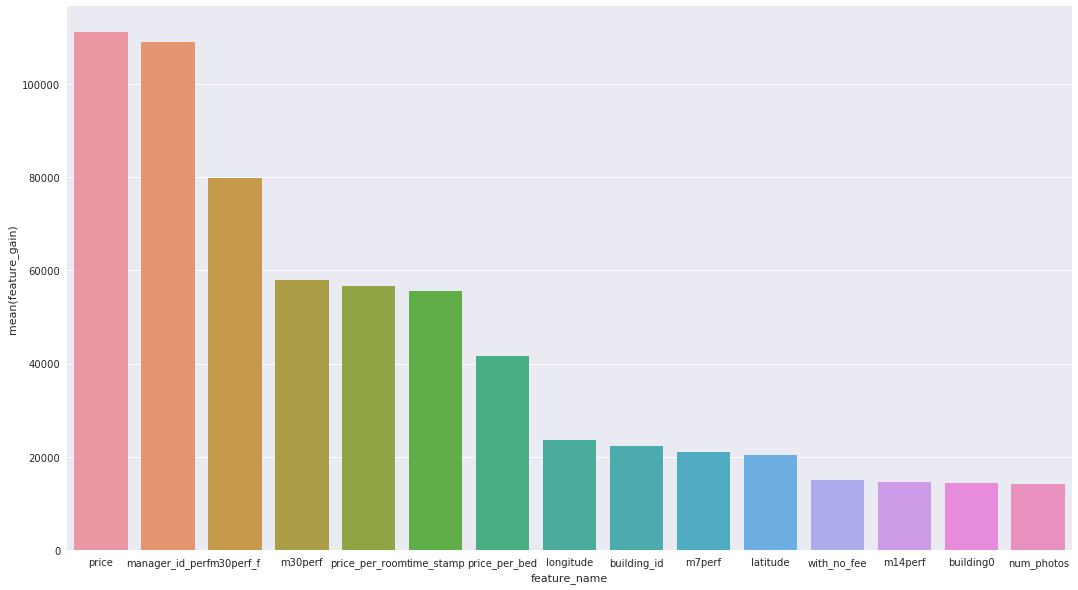

In [54]:
import seaborn as sns
plt.figure(figsize=(18, 10))
sns.barplot(x  = 'feature_name',y='feature_gain',data = importance_df[0:15])
plt.show()